# 📉 The Time-Varying Magnetic Field (Secular Variation)

During our last class, we calculated the magnetic field for a single moment in time. However, the Earth's magnetic field is **dynamic**; it changes across space and time which we call **Secular Variation**.

In this notebook, we will:
1.  **Track the Field:** Calculate how the magnetic field in Minneapolis has changed over the last 125 years.
2.  **Automate with Python:** Learn to use `for` loops and custom **Functions** to automate our calculations.
3.  **Explore Deep Time:** Apply our new tools to visualize the magnetic field in Paris, France, over the last 3,000 years according archeomagnetic models.
4.  **Map the Globe:** Generate global maps to visualize spatial variability in the field compared to a pure geocentric axial dipole (GAD) field.

In [1]:
print("⏳ Installing PmagPy and Cartopy... (this may take a moment)")
# We use --quiet to keep the output clean
!pip install pmagpy cartopy --quiet

# Standard imports for data science
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# PmagPy imports
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib

# Cartopy (map plotting)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("✅ Installation and imports complete! You are ready to go.")

⏳ Installing PmagPy and Cartopy... (this may take a moment)
✅ Installation and imports complete! You are ready to go.


## Tracking the Local Field (1900 - 2025)

We want to know what the IGRF model predicts for Minneapolis for every year from 1900 to today. We *could* write 125 lines of code... or we could use a **Loop**.

### 🐍 Python Concepts: The `for` loop
A `for` loop allows us to repeat a block of code for every item in a list.

Here is a simple `for` loop that creates a list of three years and prints them:

In [2]:
years = [2000, 2005, 2010]
for year in years:
    print(year)

2000
2005
2010


## 🔙 Review: Calculating the Field at One Point

Before we start looping through time, let's refresh our memory by calculating the field for a single moment in time.

We will calculate the current magnetic field for **Minneapolis**.
* **Latitude:** 44.97°N
* **Longitude:** -93.26°E
* **Altitude:** 0.26 km (260 meters)
* **Date:** 2025.0


In [3]:
# 1. Define location and date
lat = 44.97
lon = -93.26
alt = 0.26   # altitude in km
date = 2025.0

# 2. Pack the data into a list: [date, altitude, latitude, longitude]
input_data = [date, alt, lat, lon]

# 3. Calculate the IGRF model
result = ipmag.igrf(input_data)

# 4. Extract and print the results
dec = result[0]
inc = result[1]
B   = result[2]

print(f"Minneapolis Field in {date}:")
print(f"Declination: {dec:.1f}º")
print(f"Inclination: {inc:.1f}º")
print(f"Intensity:   {B:.1f} nT")

Minneapolis Field in 2025.0:
Declination: 359.9º
Inclination: 70.9º
Intensity:   54452.5 nT


## Looping through time

Let's get going with a `for` loop in order to calculate the field since 1900.

### The Plan
1.  Create a list of years (1900 to 2020).
2.  Loop through each year and calculate the field
3.  Save the Declination and Inclination into lists.

### Step 1: Defining the Timeline

First, we need to tell the computer which years we care about.

We could type `[1900, 1905, 1910...]` by hand, but that is tedious. Instead, we use the Python function `range()`.

* **Start:** 1900
* **Stop:** 2026 (Python stops *before* this number)
* **Step:** 1 (Every 5 years)

In [4]:
years = range(1900, 2025, 5)

# Let's print the list to make sure it looks right
print(list(years))

[1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]


### Step 2: Preparing the Storage Lists

Before we start calculating, we need a place to put the answers.

We will create two empty lists. Think of these as empty buckets. As the loop runs, we will calculate a value and throw it into the bucket.

In [5]:
dec_list = []
inc_list = []

### Step 3: The Loop

Now comes the engine. A `for` loop takes a variable (which we will call `year`) and walks through our list of `years` one by one.

**Inside the loop, we do three things:**
1.  **Pack:** Create the input list for that specific year.
2.  **Calculate:** Run `ipmag.igrf`.
3.  **Store:** Use `.append()` to add the result to our lists.

In [6]:
for year in years:
    # 1. Update the input list for the current year
    input_data = [year, alt, lat, lon]

    # 2. Run the model
    result = ipmag.igrf(input_data)

    # 3. Store the answers
    dec_list.append(result[0])
    inc_list.append(result[1])

### Step 4: Check the Data

We should now have two lists, each containing the magnetic field data for every 5 years from 1900 to 2025. Let's look at the Declination list to verify.

In [7]:
print(dec_list)

[np.float64(7.665390492202769), np.float64(7.640388564622263), np.float64(7.574761055611796), np.float64(7.5281950523091), np.float64(7.3948734542528065), np.float64(7.087430623698156), np.float64(6.857931753629866), np.float64(6.747751562509207), np.float64(6.745948658302033), np.float64(6.602598555490853), np.float64(6.483738982458862), np.float64(6.463018813077951), np.float64(6.374814985117854), np.float64(6.275779409288456), np.float64(5.840313617905794), np.float64(5.226193539826337), np.float64(4.3698236237764245), np.float64(3.6623795219774995), np.float64(3.095921046823889), np.float64(2.6010612494533083), np.float64(1.9846402290284288), np.float64(1.390339357789657), np.float64(0.8508866289094763), np.float64(0.4311746962368118), np.float64(0.161254217592757)]


### 📈 Visualizing the Data

We have the numbers, but a list of floats is hard to read. Let's plot them to see the history of the magnetic field in Minneapolis.

We want to see two things at once:
1.  How the compass direction (**Declination**) changed.
2.  How the dip angle (**Inclination**) changed.

#### 🐍 Python Concepts: Subplots
Instead of making two separate figures, we can use `plt.subplot(rows, columns, index)` to put them side-by-side.
* `plt.subplot(1, 2, 1)`: Create a grid with 1 row and 2 columns, and draw in the **1st** spot.
* `plt.subplot(1, 2, 2)`: Draw in the **2nd** spot.

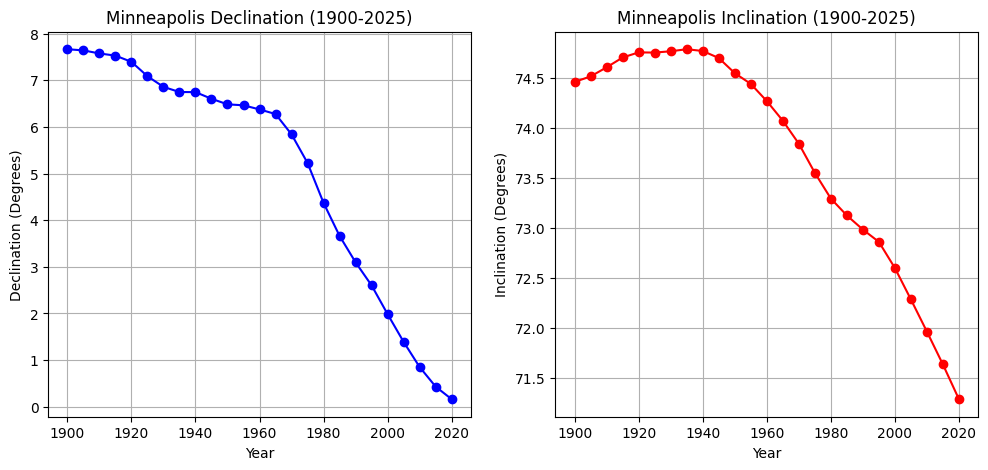

In [8]:
plt.figure(figsize=(12, 5)) # Make the figure wide

# --- Plot 1: Declination ---
plt.subplot(1, 2, 1)
plt.plot(years, dec_list, 'b-o') # Blue line ('b') with dots ('o')
plt.xlabel('Year')
plt.ylabel('Declination (Degrees)')
plt.title('Minneapolis Declination (1900-2025)')
plt.grid(True)

# --- Plot 2: Inclination ---
plt.subplot(1, 2, 2)
plt.plot(years, inc_list, 'r-o') # Red line ('r') with dots ('o')
plt.xlabel('Year')
plt.ylabel('Inclination (Degrees)')
plt.title('Minneapolis Inclination (1900-2025)')
plt.grid(True)

plt.show()

## 🛠️ Building Our Own Tools: Python Functions

Up until now, we have been using code piece by piece in combination with using functions imported form existing libraries (like `pmag.do_mag_map` or `plt.plot`). But as scientists, we will need to build our own custom tools to automate repetitive tasks. In Python, these tools are called **Functions**.

The "architecture" of a function has four main parts:

1.  **The Header (`def`):** Defines the name of your tool and the **Parameters** (inputs) it needs to do its job.
2.  **The Docstring (`"""..."""`):** The instruction manual. It explains what the function does so others (and future-you) can understand it.
3.  **The Body:** The indented block of code where the actual work happens.
4.  **The Return (`return`):** The result. This passes the finished product (data, numbers, etc.) back to you.

Let's build a function called `plot_secular_variation`. Instead of copying and pasting the same loop and plot code every time we want to check a new city, we can put the code inside of a function.

In [9]:
def plot_secular_variation(lat, lon, alt, years, model=''):
    """
    Calculates and plots the geomagnetic field over time compared to GAD expectations.

    Parameters:
    -----------
    lat : float
        Latitude in degrees.
    lon : float
        Longitude in degrees.
    alt : float
        Altitude in kilometers.
    years : list or range
        The sequence of years to calculate.
    model : str, optional
        The magnetic field model to use. Defaults to '' (IGRF).
    """

    # 1. Initialize list
    data_records = []

    # 2. Loop through the years
    for year in years:
        input_data = [year, alt, lat, lon]

        # Result = [Dec, Inc, Intensity]
        result = ipmag.igrf(input_data, mod=model)

        # Normalize Declination (-180 to 180)
        dec = result[0]
        if dec > 180:
            dec -= 360

        data_records.append({
            'Year': year,
            'Dec': dec,
            'Inc': result[1],
            'Int': result[2]
        })

    # 3. Create DataFrame
    df = pd.DataFrame(data_records)

    # 4. Calculate GAD Expected Values (The Reference Lines)
    # Expected Inc = tan^-1(2 * tan(lat))
    gad_inc = ipmag.inc_from_lat(lat)
    gad_dec = 0 # Expected dec for a GAD field is always 0 (North)

    # 5. Plotting
    model_name = model if model else "IGRF"
    plt.figure(figsize=(12, 5))

    # --- Plot 1: Declination ---
    plt.subplot(1, 2, 1)
    plt.plot(df['Year'], df['Dec'], 'b-o', label='Model SV')
    plt.axhline(gad_dec, color='k', linestyle='--', label='GAD Expected (0°)')

    plt.xlabel('Year')
    plt.ylabel('Declination (Degrees)')
    plt.title(f'{model_name} Declination: Lat {lat}, Lon {lon}')
    plt.legend()
    plt.grid(True)

    # --- Plot 2: Inclination ---
    plt.subplot(1, 2, 2)
    plt.plot(df['Year'], df['Inc'], 'r-o', label='Model SV')
    plt.axhline(gad_inc, color='k', linestyle='--', label=f'GAD Expected ({gad_inc:.1f}°)')

    plt.xlabel('Year')
    plt.ylabel('Inclination (Degrees)')
    plt.title(f'{model_name} Inclination: Lat {lat}, Lon {lon}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return df

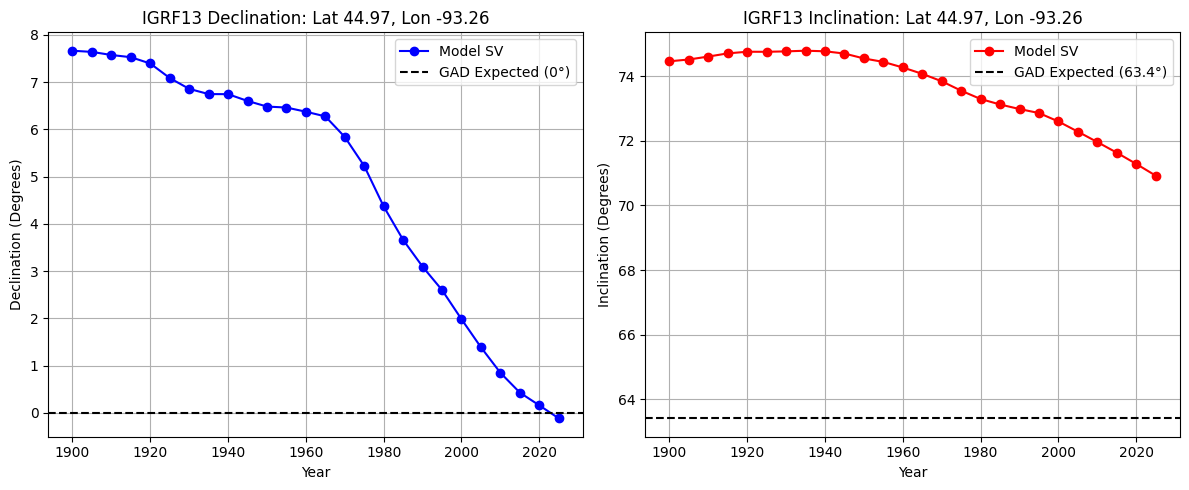

In [10]:
years = range(1900, 2030, 5)
Mpls_lat = 44.97
Mpls_lon = -93.26
Mpls_alt = 0.26   # altitude in km

sv_results = plot_secular_variation(Mpls_lat, Mpls_lon, Mpls_alt, years, model='IGRF13')

## 🧪 Put The Function to Work

Now that we have built the `plot_secular_variation` tool, let's take it for a spin.

### 1. The Modern Field (Your Choice)
First, pick **any city in the world** (your hometown, a place you want to visit, etc.).
1.  Google its Latitude and Longitude.
2.  Run your function for the years **1900 to 2020** (using the default IGRF model).

*Note: Latitude is positive North, negative South. Longitude is positive East, negative West.*

### 2. Reconstructing the Holocene Field: Models and Archives

While the IGRF relies on high-precision satellite (e.g., Swarm) and observatory measurements, reconstructing the field prior to ~1840 CE requires paleomagnetic data.

Models like `CALS10k.2` (Constrained Archeomagnetic, Lava, and Sediment model, 0-10 ka) are spherical harmonic expansions derived from three primary archives:

1.  **Archeomagnetic Data:** Anthropogenic materials such as baked clays, kilns, and hearths. Because these are often well-dated via historical records or radiocarbon, they provide high-fidelity vector data.
2.  **Volcanic Rocks:** Lava flows, which provide excellent "spot" readings of the full vector but are sporadic in time and space.
3.  **Sedimentary Records:** Lake and marine sediment cores. These provide continuous time series but can be subject to higher dating uncertainties and smoothing effects.

### Spatial Bias

Global geomagnetic models are inverse problems constrained by available data. Consequently, the reliability of these models is spatially variable.

The global dataset is heavily biased toward the Northern Hemisphere, specifically **Europe and the Middle East**, due to the high density of archeomagnetic sampling sites.  This abundance of data tightly constrains the spherical harmonic coefficients for this region, resulting in smaller error bounds on Secular Variation (SV) curves compared to the Southern Hemisphere or oceanic regions where data is sparse.

To demonstrate a "best-case scenario" for Holocene secular variation, let's examine the field vector at **Paris, France**, where the model is well-constrained.

### Analysis Task: The Paris Record

Now, use the `plot_secular_variation` function you just created to visualize the field evolution at this high-fidelity location.

**Your Task:**
1.  Define the coordinates for Paris, France (**Lat: 48.85**, **Lon: 2.35**).
2.  Use the **`cals10k.2`** model (`model='cals10k.2'`).
3.  Set the time range from **1000 BCE to 2020 CE** (i.e., years `-1000` to `2020`).
    * *Tip: A step size of 20 years is appropriate for this 3,000-year window.*

## 🌍 Mapping the Global Field

 To understand the global structure of the geomagnetic field, let's visualize data on a map.

We will use two functions from PmagPy to do this:
1.  `pmag.do_mag_map`: Calculates the field for the entire Earth.
2.  `pmagplotlib.plot_mag_map`: Visualizes the data as a heat map.

### Step 1: Generating the Grid (`do_mag_map`)

We need to generate a grid of magnetic data (Declination, Inclination, Intensity) for every latitude and longitude.

We will use the **IGRF** model for the year **2020**.

**The function inputs:**
* `date`: The year we want to map.
* `mod`: The model name (we will use `'IGRF'`).

In [11]:
# 1. Define the parameters
map_date = 2020
model_name = 'IGRF'

print(f"⏳ Calculating global {model_name} grid for {map_date}...")

# 2. Run the function
# It returns: Decs, Incs, Intensities (B), Radials (Br), Longitudes, Latitudes
Ds, Is, Bs, Brs, lons, lats = pmag.do_mag_map(map_date, mod=model_name)

print(f"✅ Calculation complete!")
print(f"Grid resolution: {len(lats)} Latitude points x {len(lons)} Longitude points")

⏳ Calculating global IGRF grid for 2020...
✅ Calculation complete!
Grid resolution: 19 Latitude points x 37 Longitude points


### Step 2: Visualizing the Map (`plot_mag_map`)

Now we can plot the data. We will create two maps:

1.  **Inclination ($I$):** Showing how the dip of the field changes from North (+90) to South (-90).
2.  **Intensity ($B$):** Showing the strength of the field.

*Note: Look for the **South Atlantic Anomaly** in the Intensity map—a large patch where the field is unusually weak.*

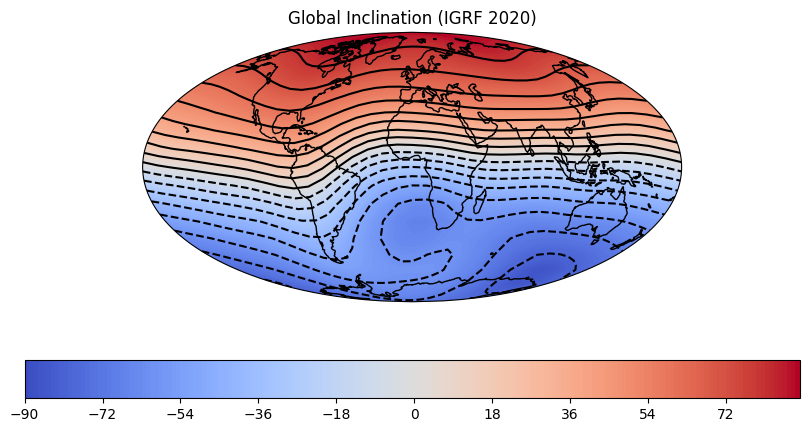

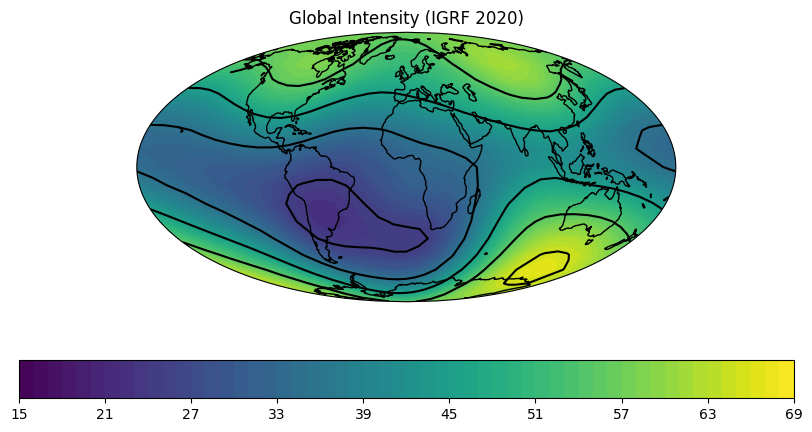

In [12]:
# --- Map 1: Inclination ---
plt.figure(figsize=(10, 5))
pmagplotlib.plot_mag_map(fignum=1,
                         element=Is, lons=lons, lats=lats,
                         element_type='I', cmap='coolwarm',
                         date=map_date, contours=True, proj='Mollweide')
plt.title(f"Global Inclination ({model_name} {map_date})")

# --- Map 2: Intensity ---
plt.figure(figsize=(10, 5))
pmagplotlib.plot_mag_map(fignum=2,
                         element=Bs, lons=lons, lats=lats,
                         element_type='B', cmap='viridis',
                         date=map_date, contours=True, proj='Mollweide')
plt.title(f"Global Intensity ({model_name} {map_date})")

plt.show()

## Snapshot vs. Long-Term Average: The GAD Hypothesis

A fundamental assumption in paleomagnetism is the **Geocentric Axial Dipole (GAD)** hypothesis. This states that the magnetic field, **when averaged over thousands of years**, aligns with the Earth's rotation axis (like a simple bar magnet).

However, at any **single snapshot in time** (like the year 2020), the field is more complex and includes non-dipole components.

By comparing the actual 2020 field to a purely GAD field, we can visualize this complexity.

**The Dipole Formula:**
For a dipole aligned with the rotation axis, the Inclination ($I$) depends only on latitude ($\lambda$):

$$\tan(I) = 2 \tan(\lambda)$$

<Figure size 1000x500 with 0 Axes>

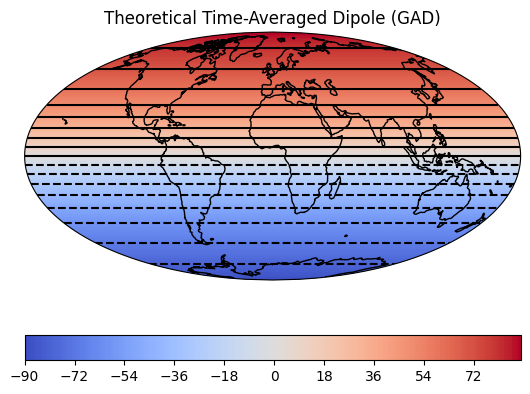

<Figure size 1000x500 with 0 Axes>

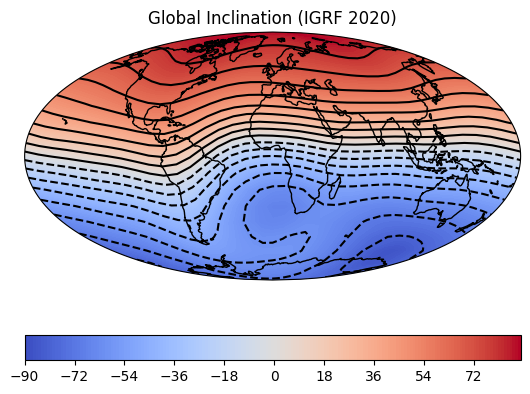

In [13]:
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Calculate the GAD Inclination for every point
# Formula: tan(I) = 2 * tan(lat)
# Note: We must convert to radians for the math, then back to degrees
lat_radians = np.deg2rad(lat_grid)
tan_inc = 2 * np.tan(lat_radians)
gad_inc_grid = np.rad2deg(np.arctan(tan_inc))

plt.figure(figsize=(10, 5))
pmagplotlib.plot_mag_map(fignum=3,
                         element=gad_inc_grid, lons=lons, lats=lats,
                         element_type='I', cmap='coolwarm',
                         date='Theoretical GAD', contours=True, proj='Mollweide')
plt.title("Theoretical Time-Averaged Dipole (GAD)")
plt.show()

plt.figure(figsize=(10, 5))
pmagplotlib.plot_mag_map(fignum=4,
                         element=Is, lons=lons, lats=lats,
                         element_type='I', cmap='coolwarm',
                         date=map_date, contours=True, proj='Mollweide')
plt.title(f"Global Inclination ({model_name} {map_date})")
plt.show()

## 🧲 Intensity: Dipole vs. Reality

Just like Inclination, the **Intensity ($B$)** of a dipole field changes predictably with latitude. The magnetic field lines are crowded together at the poles (strong field) and spread out at the equator (weak field).

**The Dipole Intensity Formula:**
$$B(\lambda) = B_{eq} \sqrt{1 + 3\sin^2(\lambda)}$$

Where $B_{eq}$ is the field strength at the equator (approx 30,000 nT).
* **At the Equator ($\lambda=0$):** $B = B_{eq}$ (Weakest)
* **At the Poles ($\lambda=90$):** $B = 2 \times B_{eq}$ (Strongest)



Let's calculate this "perfect" intensity grid and compare it to the real world.

In [14]:
# 1. Define the equatorial strength in microteslas (uT)
B_eq = 30  # uT (equivalent to 30,000 nT)

# 2. Calculate the GAD Intensity for every point
# Formula: B = Beq * sqrt(1 + 3*sin^2(lat))
# Note: lat_grid (from the previous step) is in degrees, so convert to radians
sin_lat = np.sin(np.deg2rad(lat_grid))
gad_intensity_grid = B_eq * np.sqrt(1 + 3 * sin_lat**2)

print(f"✅ Calculated GAD Intensity (Max: {gad_intensity_grid.max():.0f} nT, Min: {gad_intensity_grid.min():.0f} nT)")

✅ Calculated GAD Intensity (Max: 60 nT, Min: 30 nT)


### Visualizing the Difference

We will plot two maps:
1.  **Theoretical (GAD):** Notice the perfect horizontal bands. The field is exactly twice as strong at the poles as at the equator.
2.  **Observed (IGRF):** Notice the irregularities.

**Look closely at South America.** In the GAD model, it should be green/yellow (~30-40,000 nT). In the real data (IGRF), you will see a deep blue "hole."

<Figure size 1000x500 with 0 Axes>

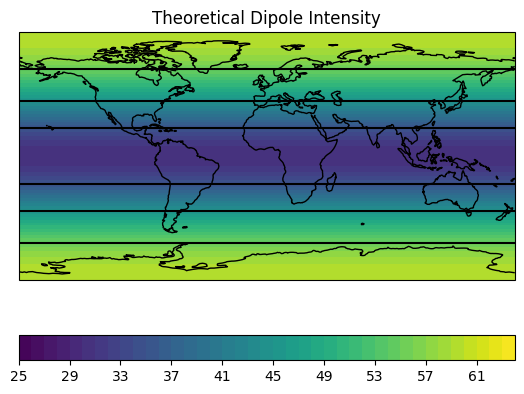

<Figure size 1000x500 with 0 Axes>

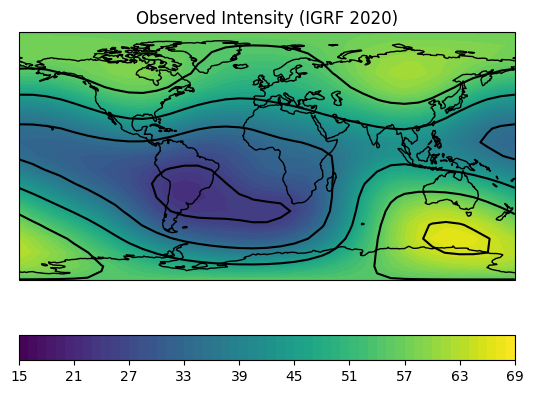

In [15]:
# --- Map 1: Theoretical Dipole Intensity ---
plt.figure(figsize=(10, 5))
pmagplotlib.plot_mag_map(fignum=6,
                         element=gad_intensity_grid, lons=lons, lats=lats,
                         element_type='B', cmap='viridis',
                         date='Theoretical Dipole', contours=True)
plt.title("Theoretical Dipole Intensity")
plt.show()

# --- Map 2: Observed Intensity (IGRF) ---
plt.figure(figsize=(10, 5))
pmagplotlib.plot_mag_map(fignum=7,
                         element=Bs, lons=lons, lats=lats, # 'Bs' was calculated earlier
                         element_type='B', cmap='viridis',
                         date='Observed (IGRF)', contours=True)
plt.title("Observed Intensity (IGRF 2020)")
plt.show()

## 🚀 Optional Extension: Animating the Field

We have looked at static snapshots of the field, but the geomagnetic field is evolving through time.

If you are interested, you can use the code below to generate a movie (GIF) showing how Earth's magnetic intensity has evolved over the last 3,000 years.

**The Goal:**
Create an animation from **1000 BCE to 2100 CE** using the `CALS10k.2` model.

**The Workflow:**
1.  **Generate Dates:** Create a list of years from -1000 to 2100.
2.  **The Loop:** Iterate through each year.
3.  **Render:** For each year, calculate the map and save it as a temporary `.png` image.
4.  **Stitch:** Combine the images into a GIF.

In [16]:
# --- OPTIONAL EXTENSION ---

# 1. Install and Import
try:
    import imageio.v2 as imageio
except ImportError:
    print("⏳ Installing imageio...")
    !pip install imageio --quiet
    import imageio.v2 as imageio

import os
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# STEP 1: Define your timeline
# TODO: Create a range of years from -1000 to 2100, stepping by 50
years = range(___, ___, ___)

files = [] # A list to track our temporary image files

print(f"🎬 Starting animation for {len(years)} frames...")

# ---------------------------------------------------------
# STEP 2: The Loop
# TODO: Write the loop to go through each 'year' in 'years'
for ___ in ___:

    # STEP 3: Calculate the Map
    # TODO: Use do_mag_map with the 'cals10k.2' model
    Ds, Is, Bs, Brs, lons, lats = pmag.do_mag_map(date=___, mod='___')

    # -----------------------------------------------------
    # Visualization (Provided)
    # -----------------------------------------------------
    plt.figure(figsize=(10, 5))

    # We force the color scale (vmin=20, vmax=70) so colors don't flicker
    pmagplotlib.plot_mag_map(fignum=1,
                             element=Bs, lons=lons, lats=lats,
                             element_type='B', cmap='jet',
                             date=f'{year} CE', contours=True)
    plt.clim(20, 70)

    # Save the frame
    filename = f'frame_{year}.png'
    plt.savefig(filename)
    files.append(filename)
    plt.close(1) # Close plot to keep notebook clean

    print(f"Rendered year: {year}", end="\r")

print("\n✅ Frames complete. Stitching GIF...")

# ---------------------------------------------------------
# STEP 4: Build the GIF (Provided)
# ---------------------------------------------------------
gif_name = 'magnetic_field_history.gif'

with imageio.get_writer(gif_name, mode='I', duration=0.2) as writer:
    for filename in files:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup temp files
for filename in files:
    if os.path.exists(filename):
        os.remove(filename)

print(f"🎉 Done! Animation saved as '{gif_name}'")

TypeError: 'str' object cannot be interpreted as an integer